# week1_02: Large scale text analysis with deep learning

Today we're gonna apply the newly learned tools for the task of predicting job salary.

<img src="https://storage.googleapis.com/kaggle-competitions/kaggle/3342/logos/front_page.png" width=400px>

Based on YSDA [materials](https://github.com/yandexdataschool/nlp_course/blob/master/week02_classification/seminar.ipynb). _Special thanks to [Oleg Vasilev](https://github.com/Omrigan/) for the core assignment idea._

In [1]:
from collections import Counter

import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import torch
from IPython.display import clear_output
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split
from torch import nn
from tqdm import tqdm, tqdm_notebook  # noqa: F401

## About the challenge

We have to predict salary by Title, Description and some Categories of a position.

For more information checkout [the competition page](https://www.kaggle.com/c/job-salary-prediction).

In [2]:
from pathlib import Path
import urllib.request
import zipfile

In [3]:
url = 'https://gin.g-node.org/v-goncharenko/ml-mipt/raw/master/data/Train_rev1.csv.zip'
zip_name = url.split('/')[-1]

curr_dir = Path().resolve()
datasets_dir = curr_dir.parent / 'datasets'
if not datasets_dir.exists():
    datasets_dir = curr_dir

compressed_data_path = datasets_dir / zip_name
if not compressed_data_path.exists():
    print('Downloading data...')
    urllib.request.urlretrieve(url, compressed_data_path)

data_path = datasets_dir / compressed_data_path.stem
if not data_path.exists():
    print('Unpacking...')
    with zipfile.ZipFile(compressed_data_path, 'r') as zip_file:
        zip_file.extractall(datasets_dir)
    
print('Done!')

Done!


If for some reason code above failed, you could download and unpack the data manually from [gin](https://gin.g-node.org/v-goncharenko/ml-mipt/raw/master/data/Train_rev1.csv.zip), [dropbox](https://www.dropbox.com/s/5msc5ix7ndyba10/Train_rev1.csv.tar.gz?dl=0) or [yadisk](https://yadi.sk/d/vVEOWPFY3NruT7).\
Alternative download it [directly from kaggle](https://www.kaggle.com/c/job-salary-prediction/data).

In [4]:
data = pd.read_csv(data_path, index_col=None)
data.shape

(244768, 12)

One problem with salary prediction is that it's oddly distributed: there are many people who are paid standard salaries and a few that get tons o money. The distribution is fat-tailed on the right side, which is inconvenient for MSE minimization.

There are several techniques to combat this: using a different loss function, predicting log-target instead of raw target or even replacing targets with their percentiles among all salaries in the training set. We gonna use logarithm for now.

_You can read more [in the official description](https://www.kaggle.com/c/job-salary-prediction#description)._

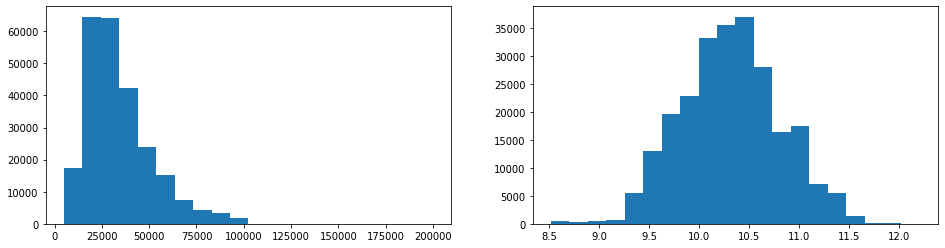

In [5]:
data["Log1pSalary"] = np.log1p(data["SalaryNormalized"]).astype("float32")

plt.figure(figsize=[16, 4])

plt.subplot(1, 2, 1)
plt.hist(data["SalaryNormalized"], bins=20)

plt.subplot(1, 2, 2)
plt.hist(data["Log1pSalary"], bins=20)

plt.show()

Our task is to predict one number, __Log1pSalary__.

To do so, our model can access a number of features:
* Free text: __`Title`__ and  __`FullDescription`__
* Categorical: __`Category`__, __`Company`__, __`LocationNormalized`__, __`ContractType`__, and __`ContractTime`__.

In [6]:
text_columns = ["Title", "FullDescription"]
categorical_columns = ["Category", "Company", "LocationNormalized", "ContractType", "ContractTime"]
target_column = "Log1pSalary"

# cast missing values to string "NaN"
data[categorical_columns] = data[categorical_columns].fillna("NaN")

data.sample(3)

,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName,Log1pSalary
118292,69805946,Financial Services Sales Executive Face to Fa...,An exciting opportunity is available for an ex...,Wolverhampton West Midlands (County) West Midl...,UK,NaN,permanent,Select Appointments,Accounting & Finance Jobs,"From 20,000 to 24,000 per annum + OTE",22000,totaljobs.com,9.998843
171388,71374781,ENGINEERING SUPERVISOR LIMAVADY,Experienced Engineering Supervisor for busy cl...,Ulster,UK,full_time,permanent,Industrial Temps,Engineering Jobs,15000 - 25000,20000,nijobs.com,9.903538
188335,71686287,Sales Coordinator 6 month contract,Sales Support/Sales Administrator/Sales Coordi...,"York,knaresborough,harrogate",UK,NaN,contract,Travail Employment Group,Admin Jobs,14500 - 17500 pa,16000,jobsite.co.uk,9.680407


## Preprocessing text data

Just like last week, applying NLP to a problem begins from tokenization: splitting raw text into sequences of tokens (words, punctuation, etc).

__Your task__ is to lowercase and tokenize all texts under `Title` and `FullDescription` columns. Store the tokenized data as a __space-separated__ string of tokens for performance reasons.

It's okay to use nltk tokenizers. Assertions were designed for WordPunctTokenizer, slight deviations are okay.

In [7]:
print("Raw text:")
print(data["FullDescription"][2::100000])

Raw text:
2         Mathematical Modeller / Simulation Analyst / O...
100002    A successful and high achieving specialist sch...
200002    Web Designer  HTML, CSS, JavaScript, Photoshop...
Name: FullDescription, dtype: object


In [ ]:
def normalize(text):
    # YOUR CODE HERE: see task above
    return None

In [ ]:
tokenizer = nltk.tokenize.WordPunctTokenizer()

data[text_columns] = data[text_columns].applymap(normalize)

Now we can assume that our text is a space-separated list of tokens:

In [ ]:
print("Tokenized:")
print(data["FullDescription"][2::100000])
assert data["FullDescription"][2][:50] == "mathematical modeller / simulation analyst / opera"
assert data["Title"][54321] == "international digital account manager ( german )"

Not all words are equally useful. Some of them are typos or rare words that are only present a few times. 

Let's count how many times is each word present in the data so that we can build a "white list" of known words.

In [ ]:
# YOUR CODE HERE: count how many times does each token occurs in both "Title"
# and "FullDescription" in total, build a dictionary { token -> it's count }
token_counts = None

# hint: collections.Counter can be useful here

In [ ]:
print("Total unique tokens :", len(token_counts))
print("\n".join(map(str, token_counts.most_common(n=5))))
print("...")
print("\n".join(map(str, token_counts.most_common()[-3:])))

assert token_counts.most_common(1)[0][1] in range(2600000, 2700000)
assert len(token_counts) in range(200000, 210000)
print("Correct!")

In [ ]:
# Let's see how many words are there for each count
plt.hist(list(token_counts.values()), range=[0, 10 ** 4], bins=50, log=True)
plt.xlabel("Word counts");

Now filter tokens a list of all tokens that occur at least 10 times.

In [ ]:
min_count = 10

# YOUR CODE HERE: chose tokens from token_counts keys that
# had at least min_count occurrences throughout the dataset
tokens = None

In [ ]:
# Add a special tokens for unknown and empty words
UNK, PAD = "UNK", "PAD"
tokens = [UNK, PAD] + sorted(tokens)
print("Vocabulary size:", len(tokens))

assert type(tokens) == list
assert len(tokens) in range(32000, 35000)
assert "me" in tokens
assert UNK in tokens
print("Correct!")

Build an inverse token index: a dictionary from token(string) to it's index in `tokens` (int)

In [ ]:
# YOUR CODE HERE: you have already done that ;)
token_to_id = None

In [ ]:
assert isinstance(token_to_id, dict)
assert len(token_to_id) == len(tokens)
for tok in tokens:
    assert tokens[token_to_id[tok]] == tok

print("Correct!")

And finally, let's use the vocabulary you've built to map text lines into neural network-digestible matrices.

In [ ]:
UNK_IX, PAD_IX = map(token_to_id.get, [UNK, PAD])


def as_matrix(sequences, max_len=None):
    """ Convert a list of tokens into a matrix with padding """
    if isinstance(sequences[0], str):
        sequences = list(map(str.split, sequences))

    max_len = min(max(map(len, sequences)), max_len or float("inf"))

    matrix = np.full((len(sequences), max_len), np.int32(PAD_IX))
    for idx, seq in enumerate(sequences):
        row_ix = [token_to_id.get(word, UNK_IX) for word in seq[:max_len]]
        matrix[idx, : len(row_ix)] = row_ix

    return matrix

In [ ]:
print("Lines:")
print("\n".join(data["Title"][::100000].values), end="\n\n")
print("Matrix:")
print(as_matrix(data["Title"][::100000]))

Now let's  encode the categirical data we have.

As usual, we shall use one-hot encoding for simplicity. Kudos if you implement more advanced encodings: tf-idf, pseudo-time-series, etc.

In [ ]:
# we only consider top-1k most frequent companies to minimize memory usage
top_companies, top_counts = zip(*Counter(data["Company"]).most_common(1000))
recognized_companies = set(top_companies)
data["Company"] = data["Company"].apply(
    lambda comp: comp if comp in recognized_companies else "Other"
)

categorical_vectorizer = DictVectorizer(dtype=np.float32, sparse=False)
categorical_vectorizer.fit(data[categorical_columns].apply(dict, axis=1))

## The deep learning part

Once we've learned to tokenize the data, let's design a machine learning experiment.

As before, we won't focus too much on validation, opting for a simple train-test split.

__To be completely rigorous,__ we've comitted a small crime here: we used the whole data for tokenization and vocabulary building. A more strict way would be to do that part on training set only. You may want to do that and measure the magnitude of changes.

In [ ]:
data_train, data_val = train_test_split(data, test_size=0.2, random_state=42)
data_train.index = range(len(data_train))
data_val.index = range(len(data_val))

print("Train size = ", len(data_train))
print("Validation size = ", len(data_val))

In [ ]:
def make_batch(data, max_len=None, word_dropout=0):
    """
    Creates a keras-friendly dict from the batch data.
    :param word_dropout: replaces token index with UNK_IX with this probability
    :returns: a dict with {'title' : int64[batch, title_max_len]
    """
    batch = {}
    batch["Title"] = as_matrix(data["Title"].values, max_len)
    batch["FullDescription"] = as_matrix(data["FullDescription"].values, max_len)
    batch["Categorical"] = categorical_vectorizer.transform(
        data[categorical_columns].apply(dict, axis=1)
    )

    if word_dropout != 0:
        batch["FullDescription"] = apply_word_dropout(batch["FullDescription"], 1.0 - word_dropout)

    if target_column in data.columns:
        batch[target_column] = data[target_column].values

    return batch


def apply_word_dropout(
    matrix,
    keep_prop,
    replace_with=UNK_IX,
    pad_ix=PAD_IX,
):
    dropout_mask = np.random.choice(2, np.shape(matrix), p=[keep_prop, 1 - keep_prop])
    dropout_mask &= matrix != pad_ix
    return np.choose(dropout_mask, [matrix, np.full_like(matrix, replace_with)])

In [ ]:
make_batch(data_train[:3], max_len=10)

#### Architecture

Our main model consists of three branches:
* Title encoder
* Description encoder
* Categorical features encoder

We will then feed all 3 branches into one common network that predicts salary.

<img src="https://github.com/yandexdataschool/nlp_course/raw/master/resources/w2_conv_arch.png" width=600px>

This clearly doesn't fit into PyTorch __Sequential__ interface. To build such a network, one will have to use [__PyTorch nn.Module API__](https://pytorch.org/docs/stable/nn.html#torch.nn.Module).

But to start with let's build the simple model using only the part of the data. Let's create the baseline solution using only the description part (so it should definetely fit into the Sequential model).

In [ ]:
# You will need this to make it simple


class Reorder(nn.Module):
    def forward(self, input):
        return input.permute((0, 2, 1))

Also keep in mind [`torch.nn.Flatten` module](https://pytorch.org/docs/stable/generated/torch.nn.Flatten.html)

To generate batches we will use simple pyton generator.

In [ ]:
def iterate_batches(data, batch_size=256, shuffle=True, cycle=False, **kwargs):
    """ iterates batches of data in random order """
    while True:
        indices = np.arange(len(data))
        if shuffle:
            indices = np.random.permutation(indices)

        for start in range(0, len(indices), batch_size):
            batch = make_batch(data.iloc[indices[start : start + batch_size]], **kwargs)
            target = batch.pop(target_column)
            yield batch, target

        if not cycle:
            break

In [ ]:
iterator = iterate_batches(data_train, 3)
batch, target = next(iterator)

In [ ]:
# Here is some startup code:
n_tokens = len(tokens)
n_cat_features = len(categorical_vectorizer.vocabulary_)
hid_size = 64
simple_model = nn.Sequential()

simple_model.add_module("emb", nn.Embedding(num_embeddings=n_tokens, embedding_dim=hid_size))
simple_model.add_module("reorder", Reorder())
# YOUR CODE HERE: complete the model

__Remember!__ We are working with regression problem and predicting only one number.

In [ ]:
# Try this to check your model. `torch.long` tensors are required for nn.Embedding layers.
simple_model(torch.tensor(batch["FullDescription"], dtype=torch.long))

And now simple training pipeline:

In [ ]:
epochs = 1

model = simple_model
opt = torch.optim.Adam(model.parameters())

# YOUR CODE HERE: pick the loss function
loss_func = None

history = []
for epoch_num in range(epochs):
    for idx, (batch, target) in enumerate(iterate_batches(data_train)):
        # Preprocessing the batch data and target
        batch = torch.tensor(batch["FullDescription"], dtype=torch.long)
        target = torch.tensor(target)

        predictions = model(batch)
        predictions = predictions.view(predictions.size(0))

        # YOUR CODE HERE
        loss = None

        # YOUR CODE HERE: train with backprop

        history.append(loss.data.numpy())
        if (idx + 1) % 10 == 0:
            clear_output(True)
            plt.plot(history, label="loss")
            plt.legend()
            plt.show()

To evaluate the model it can be switched to `eval` state.

In [ ]:
simple_model.eval()

Let's check the model quality.

In [ ]:
def print_metrics(model, data, batch_size=256, name="", **kw):
    squared_error = abs_error = num_samples = 0.0
    for batch_x, batch_y in tqdm(
        iterate_batches(data, batch_size=batch_size, shuffle=False, **kw)
    ):
        batch = torch.tensor(batch_x["FullDescription"], dtype=torch.long)
        batch_pred = simple_model(batch)[:, 0].detach().numpy()
        squared_error += np.sum(np.square(batch_pred - batch_y))
        abs_error += np.sum(np.abs(batch_pred - batch_y))
        num_samples += len(batch_y)
    print("%s results:" % (name or ""))
    print("Mean square error: %.5f" % (squared_error / num_samples))
    print("Mean absolute error: %.5f" % (abs_error / num_samples))
    return squared_error, abs_error


print_metrics(simple_model, data_train, name="Train")
print_metrics(simple_model, data_val, name="Val");

## Bonus area: three-headed network.

Now you can try to implement the network we've discussed above. Use [__PyTorch nn.Module API__](https://pytorch.org/docs/stable/nn.html#torch.nn.Module).

In [ ]:
class ThreeInputsNet(nn.Module):
    def __init__(
        self,
        n_tokens=len(tokens),
        n_cat_features=len(categorical_vectorizer.vocabulary_),
        hid_size=64,
    ):
        super().__init__()

        self.title_emb = nn.Embedding(n_tokens, embedding_dim=hid_size)
        # YOUR CODE HERE: you may add some layers here

        self.full_emb = nn.Embedding(num_embeddings=n_tokens, embedding_dim=hid_size)
        # YOUR CODE HERE: you may add some layers here

        self.category_out = None  # YOUR CODE HERE

    def forward(self, whole_input):
        input1, input2, input3 = whole_input
        title_beg = self.title_emb(input1).permute((0, 2, 1))  # noqa: F841
        title = None  # YOUR CODE HERE

        full_beg = self.full_emb(input2).permute((0, 2, 1))  # noqa: F841
        full = None  # YOUR CODE HERE

        category = None  # YOUR CODE HERE

        concatenated = torch.cat(  # noqa: F841
            [
                title.view(title.size(0), -1),
                full.view(full.size(0), -1),
                category.view(category.size(0), -1),
            ],
            dim=1,
        )

        out = None  # YOUR CODE HERE
        return out

## Bonus area 2: comparing RNN to CNN

Try implementing simple RNN (or LSTM) and applying it to this task. Compare the quality/performance of these networks. 

*Hint: try to build networks with ~same number of paremeters.*

In [ ]:
# YOUR CODE HERE

## Bonus area 3: fixing the data leaks

Fix the data leak we ignored in the beginning of the __Deep Learning part__.\
Compare results with and without data leaks using same architectures and training time.

In [ ]:
# YOUR CODE HERE

__Terrible start-up idea #1962:__ make a tool that automaticaly rephrases your job description (or CV) to meet salary expectations :)